In [65]:
# magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [479]:
# Custom functions and tools 
import sys
sys.path.insert(1, '../../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models
from evaluate import evaluate as evaluate
import gpmcmc as gp_my_data

In [480]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')

In [846]:
time = np.linspace(-100, 100, 250) + np.random.normal(2, 140, 250)
time = time[np.argsort(time)]
model = dip_models.skew_norm(time, -155, 5, 0, 16, 0.1) + np.random.normal(0, 0.001, len(time))
model_err = abs(np.random.normal(0.001, 0.001, 250))

In [878]:
time[time-np.roll(time, 3) < 1e-5]

array([-417.47349772, -346.61310376, -337.55053137])

In [886]:
tt = np.array([0, 0.0, 0.0, 0.0, 1])

In [890]:
abs(tt-np.roll(tt, 1))>1e-5

array([ True, False, False, False,  True])

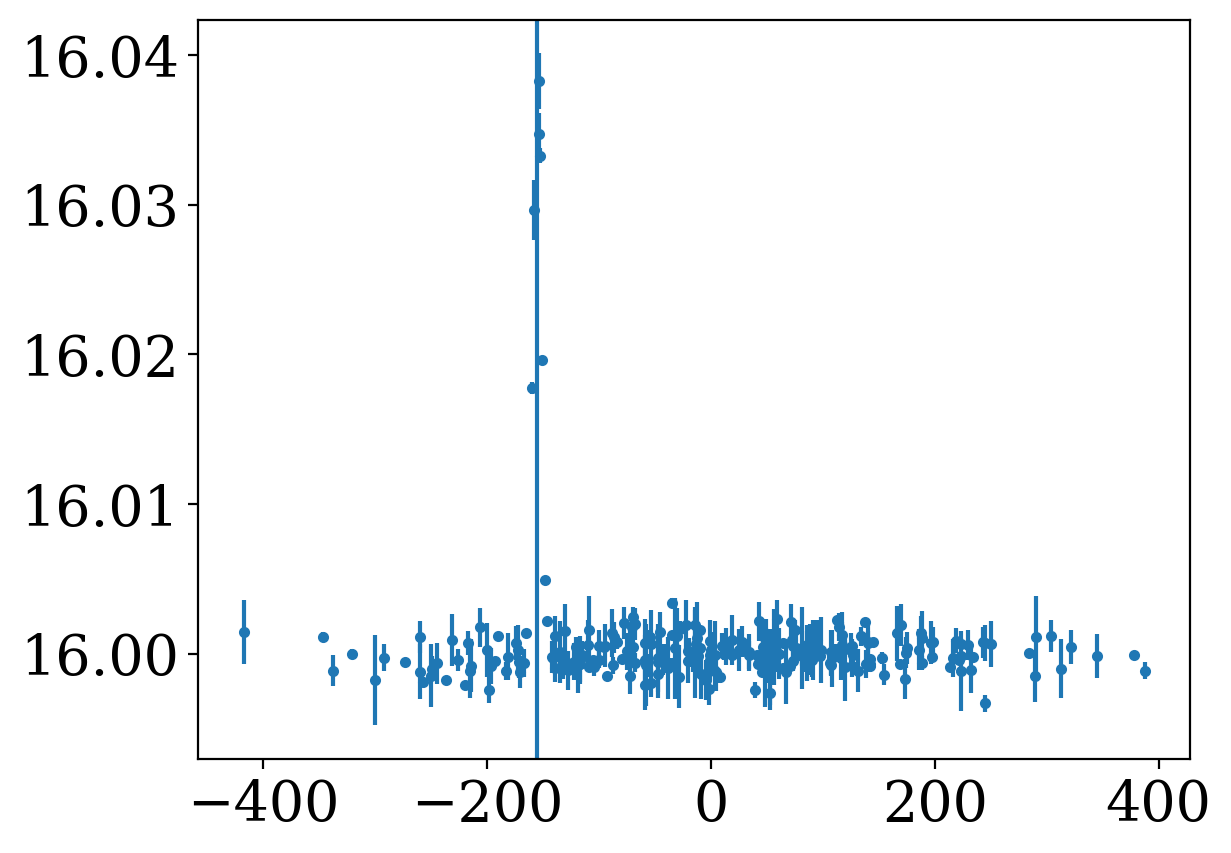

In [847]:
plt.errorbar(time, model, model_err, fmt='.')
plt.axvline(-155)

In [567]:
def double_to_single_step(cads):
    """Ratios ``(t[i+2] - t[i]) / (t[i+1] - t[i]``)."""
    cads = np.asarray(cads)
    return (cads[2:] + cads[:-2]) / (cads[1:-1] - cads[:-2])


def cad_prob(cads, time):
    """Given the observed distribution of time lags `cads`, compute the probability
    that the next observation occurs within `time` minutes of an arbitrary epoch.
    """
    return stats.percentileofscore(cads, float(time) / (24.0 * 60.0)) / 100.0


def delta_t_hist(t, nbins=50, conv_oversample=50):
    """Build histogram of all possible ``|t_i - t_j|``'s.

    For efficiency, we construct the histogram via a convolution of the PDF
    rather than by actually computing all the differences. For better accuracy
    we use a factor `conv_oversample` more bins when performing the convolution
    and then aggregate the result to have `nbins` total values.
    """
    f, x = np.histogram(t, bins=conv_oversample * nbins)
    g = np.convolve(f, f[::-1])[len(f) - 1 :]  # Discard negative domain
    g[0] -= len(t)  # First bin is double-counted because of i=j terms
    hist = g.reshape((-1, conv_oversample)).sum(axis=1)  # Combine bins
    return hist


def normalize_hist(hist, total_time):
    """Normalize histogram such that integral from ``t_min`` to ``t_max`` equals 1.
    cf. ``np.histogram(..., density=True)``.
    """
    return hist / (total_time * np.mean(hist))


def find_sorted_peaks(x):
    """Find peaks, i.e. local maxima, of an array. Interior points are peaks if
    they are greater than both their neighbors, and edge points are peaks if
    they are greater than their only neighbor. In the case of ties, we
    (arbitrarily) choose the first index in the sequence of equal values as the
    peak.
    Returns a list of tuples ``(i, x[i])`` of peak indices ``i`` and values
    ``x[i]``, sorted in decreasing order by peak value.
    """
    peak_inds = []
    nbins = len(x)
    for i in range(nbins):
        if i == 0 or x[i] > x[i - 1]:  # Increasing from left
            if i == nbins - 1 or x[i] > x[i + 1]:  # Increasing from right
                peak_inds.append(i)
            elif x[i] == x[i + 1]:  # Tied; check the next non-equal value
                for j in range(i + 1, nbins):
                    if x[j] != x[i]:
                        if x[j] < x[i]:
                            peak_inds.append(i)
                        break
                if j == nbins - 1 and x[i] == x[j]:  # Reached the end
                    peak_inds.append(i)
    sorted_peak_inds = sorted(peak_inds, key=lambda i: x[i], reverse=True)
    return list(zip(sorted_peak_inds, x[sorted_peak_inds]))


def peak_ratio(peaks, i, j):
    """Compute the ratio of the values of the ith and jth largest peaks. Peaks is a list
    of tuples ``(i, x[i])`` of peak indices ``i`` and values ``x[i]``, sorted in decreasing order
    by peak value.
    """
    if len(peaks) > i and len(peaks) > j:
        return peaks[i][1] / peaks[j][1]
    else:
        return np.nan


def peak_bin(peaks, i):
    """Return the (bin) index of the ith largest peak. Peaks is a list of tuples
    ``(i, x[i])`` of peak indices ``i`` and values ``x[i]``, sorted in
    decreasing order by peak value.
    """
    if len(peaks) > i:
        return peaks[i][0]
    else:
        return np.nan

import scipy.stats as stats

In [607]:
x = (time)
y = model
xmin, xmax = min(time), max(time)
ymin, ymax = min(y), max(y)

In [608]:
# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = stats.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)


Text(0, 0.5, '$\\Delta$Mag')

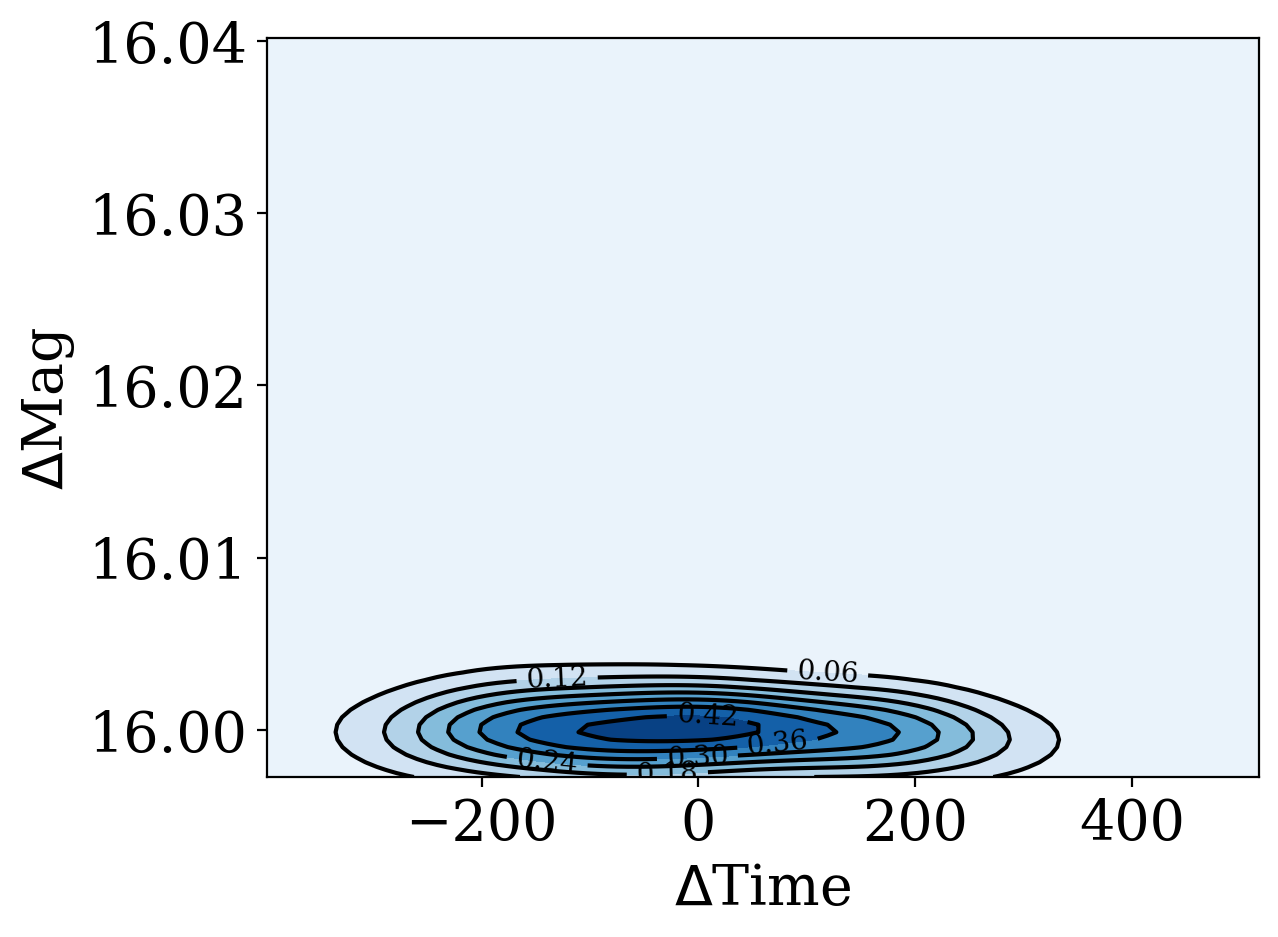

In [610]:
fig = plt.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('$\Delta$Time')
ax.set_ylabel('$\Delta$Mag')

In [716]:
from scipy.stats import multivariate_normal
import numpy as np
x = np.array([[0,.1],
             ])

a = multivariate_normal.pdf(x, mean=[0, 0], cov=[0.1, 0.2])

In [750]:
N = 6500
X = np.zeros(shape=(N, 2))
X[:,0] = np.random.normal(0, 2, N)
X[:,1] = np.random.normal(0, 2, N)

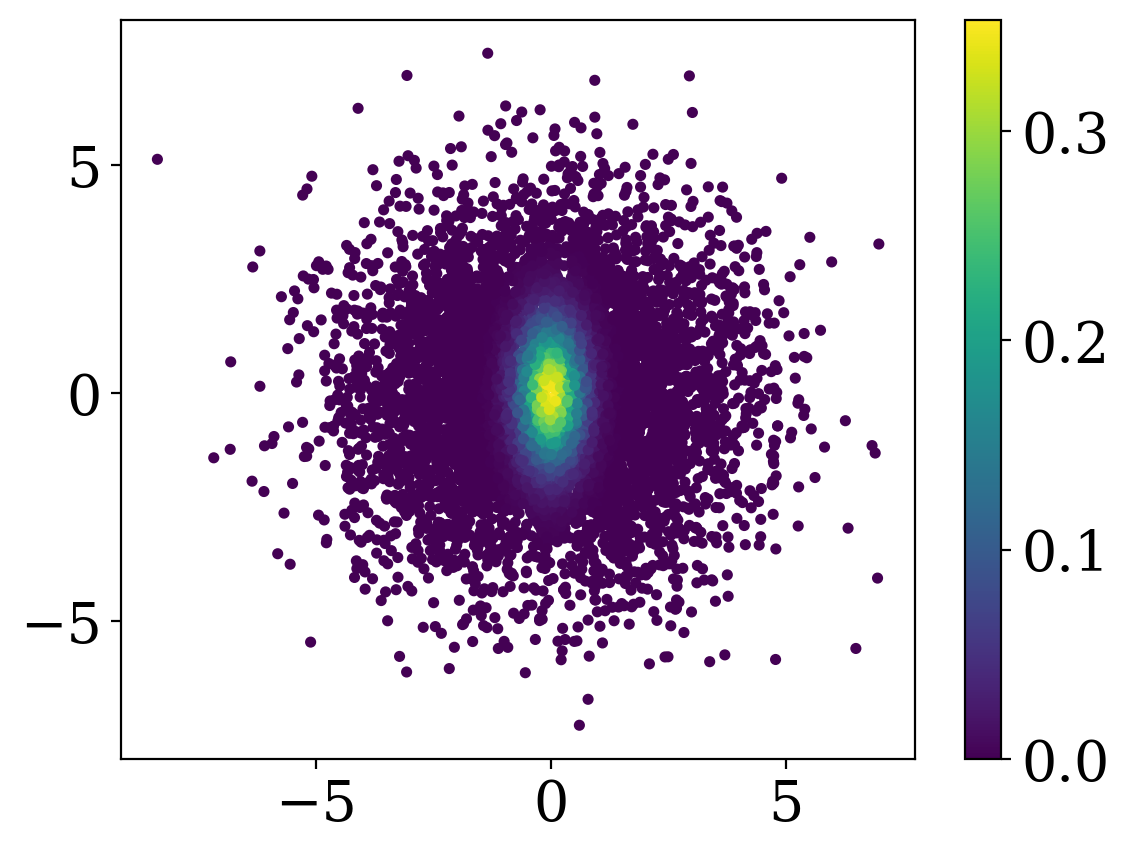

In [752]:
plt.scatter(X[:,0], X[:,1],
            c=multivariate_normal.pdf(X,
                                      mean=[0, 0], cov=[0.2, 1]), 
           marker='.',)
plt.colorbar()

In [686]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

# Data
x = np.array([[1, 2],
              [3, 4],
             [-0.5, 3.2]])

# Parameters for the multivariate normal distribution
mean = [0, 0]
covariance_matrix = [[1, 0.2], [0.2, 1]]

# Create a grid of values
x1, x2 = np.meshgrid(np.linspace(-1, 5, 100), np.linspace(-1, 5, 100))
pos = np.dstack((x1, x2))

# Calculate PDF values
pdf_values = multivariate_normal.pdf(pos, mean=mean, cov=covariance_matrix)


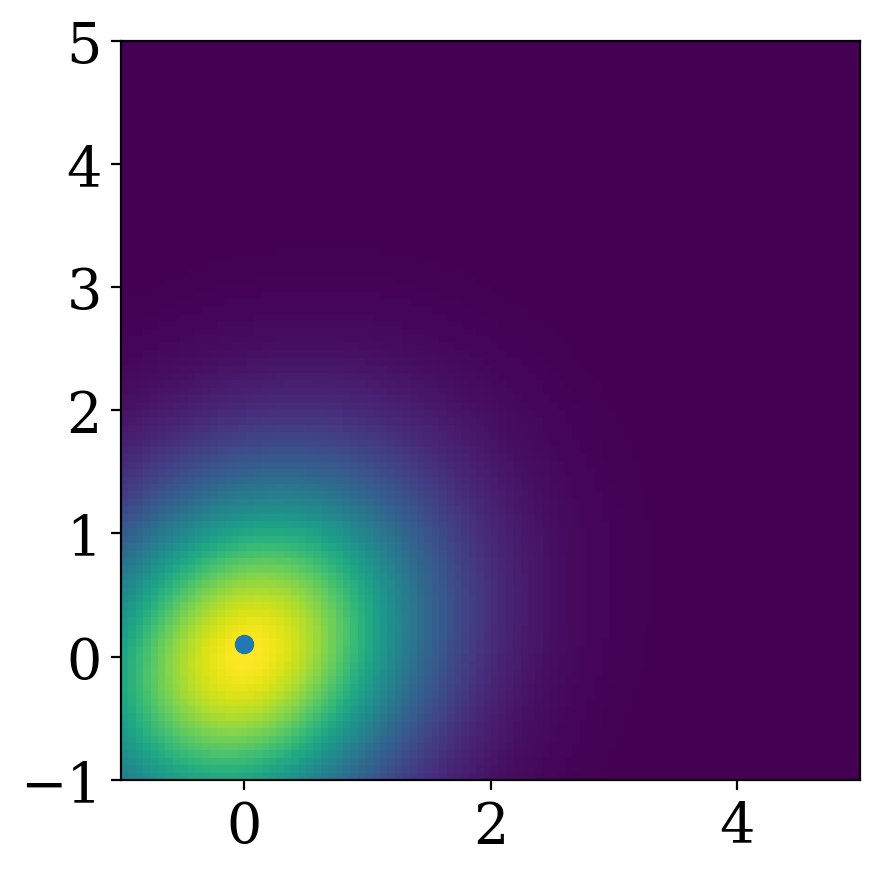

In [692]:
plt.imshow(pdf_values, origin='lower', 
          extent=[-1, 5, -1, 5])
plt.scatter(0, 0.1)

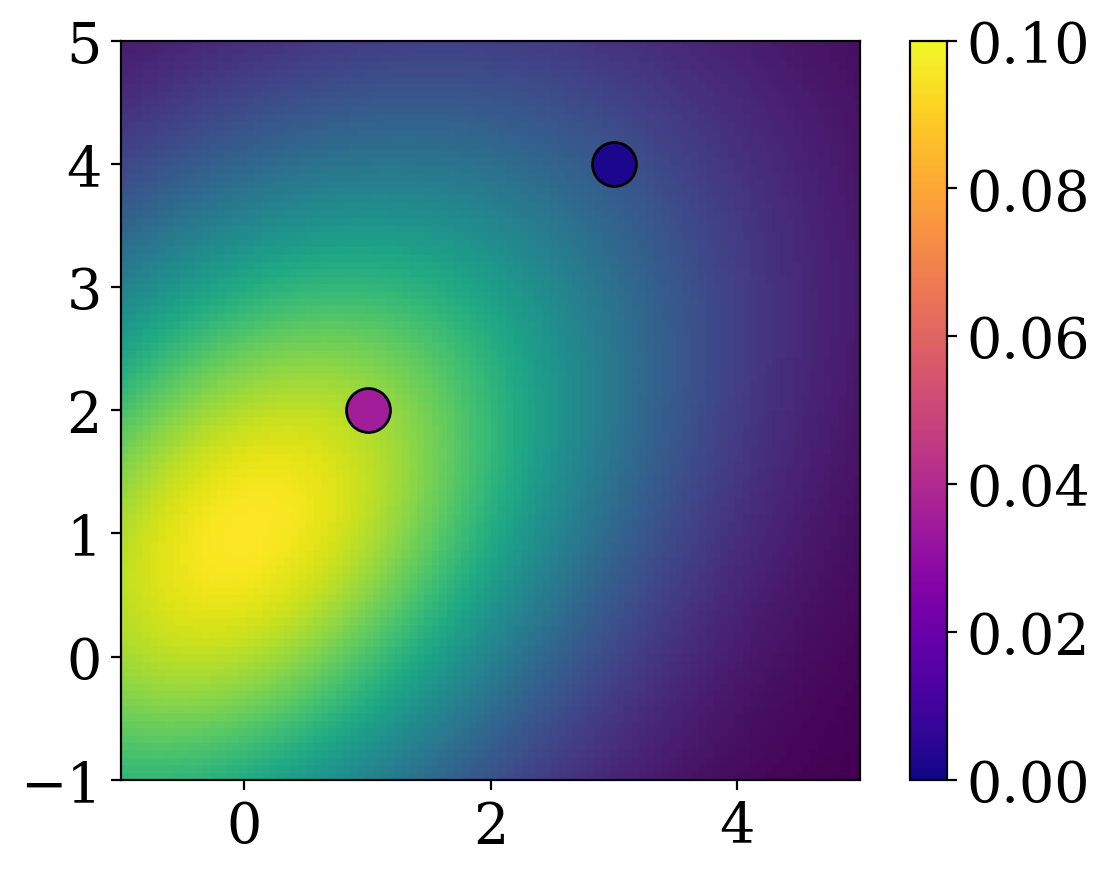

In [679]:
_ = plt.imshow(pdf_values, 
              extent=[-1, 5, -1, 5], 
              origin='lower')


plt.scatter(1, 2, edgecolor='k', s=250, c=0.0354664, cmap='plasma', 
           vmin=0, vmax=0.1)

plt.scatter(3, 4, edgecolors='k', s=250, c=0.00215671, cmap='plasma', 
           vmin=0, vmax=0.1)



plt.colorbar()

In [578]:
dts = delta_t_hist(time, nbins=50, conv_oversample=10)
peaks = find_sorted_peaks(model)
pt = [time[p[0]] for p in peaks]
ratp = [p[1] for p in peaks]

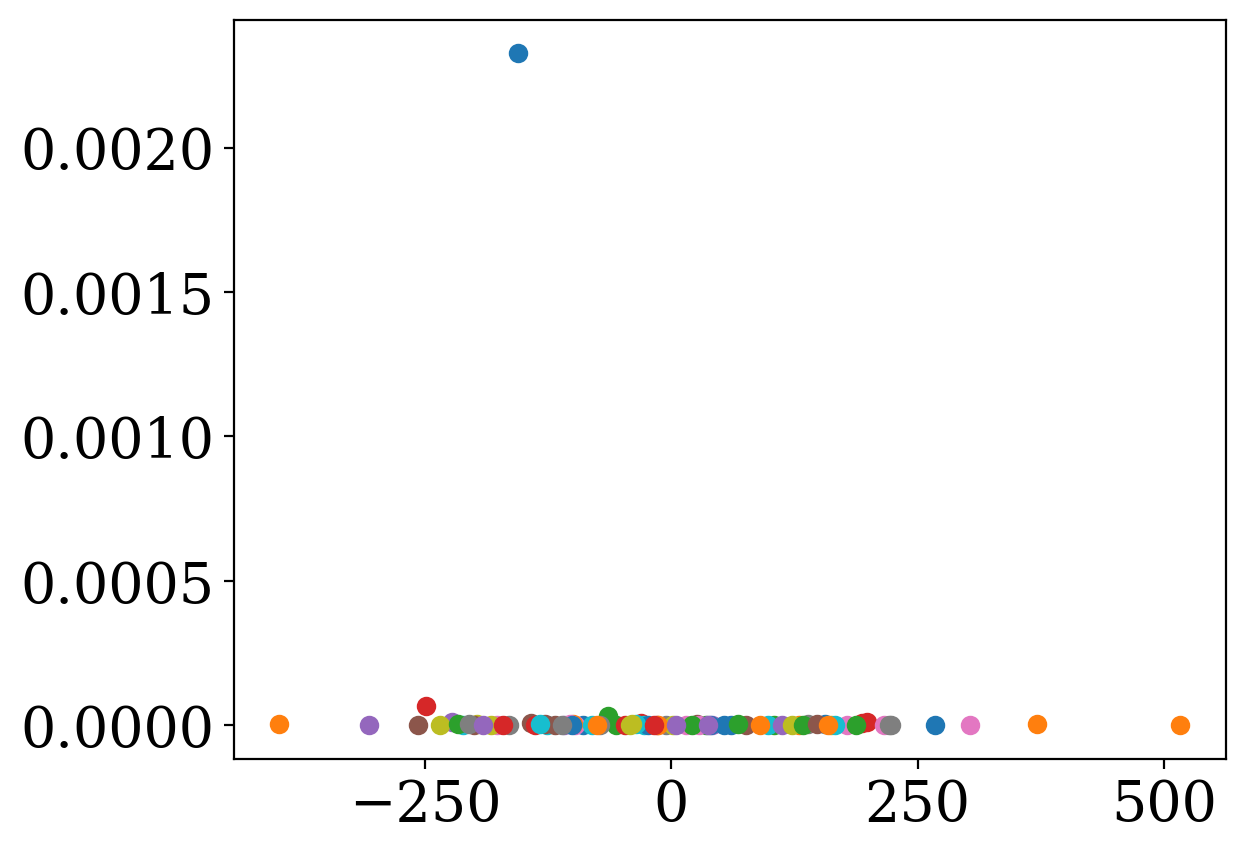

In [586]:
for i in range(0, len(ratp)-1):
    plt.scatter(pt[i], 1-(ratp[i+1]/ratp[i]))

In [573]:
peak_ratio()

array([1962, 2032, 1911, 1961, 1894, 1770, 1744, 1652, 1589, 1536, 1367,
       1350, 1248, 1135, 1015,  914,  858,  804,  683,  630,  566,  477,
        413,  307,  270,  217,  159,  149,  113,   95,   74,   63,   52,
         57,   27,   21,   19,   19,   12,   17,    5,    6,    3,    3,
          1,    3,    0,    1,    0,    1])

<ErrorbarContainer object of 3 artists>

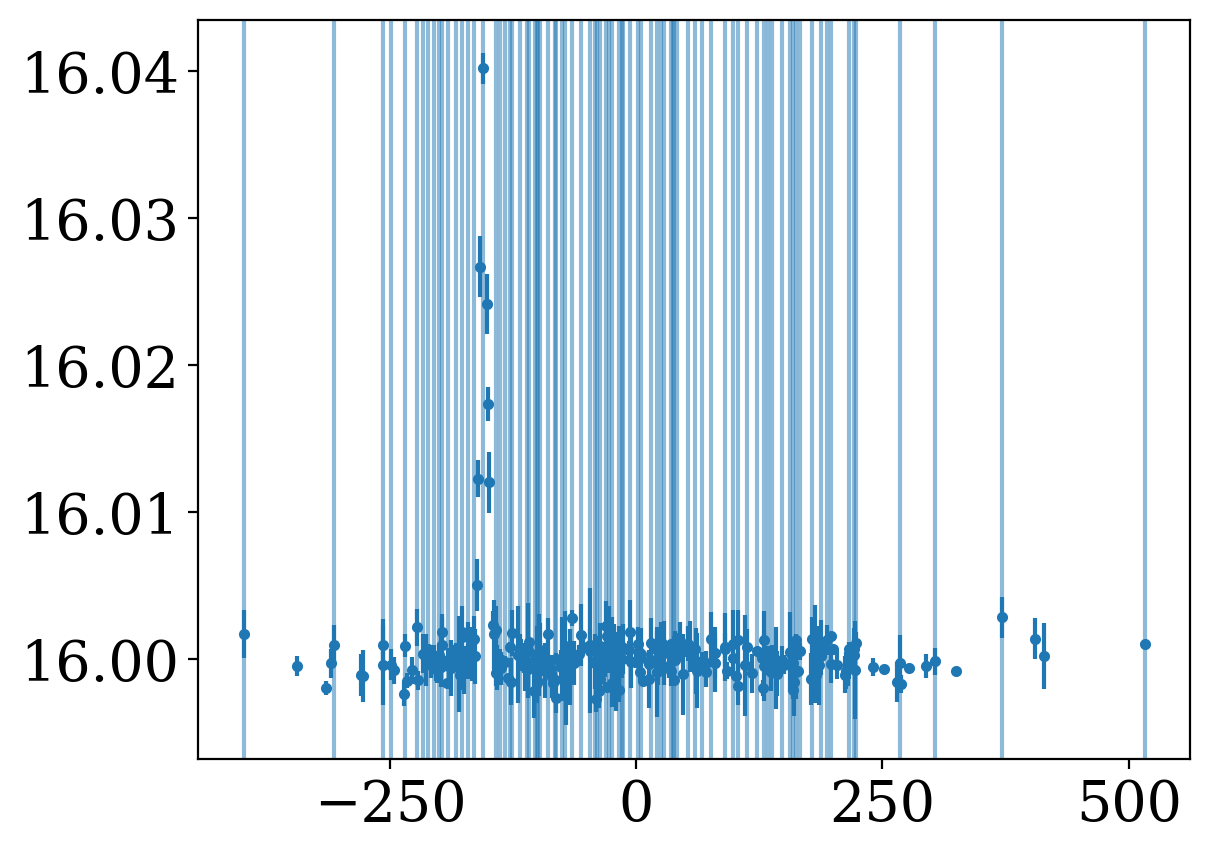

In [572]:
for j in find_sorted_peaks(model):
    plt.axvline(time[j[0]], alpha=0.5)

plt.errorbar(time, model, model_err, fmt='.')

In [754]:
from sklearn.cluster import DBSCAN

In [792]:
N = 2_000
X = np.zeros(shape=(N, 2))
X[0:1_000,0] = np.random.normal(0, 1, 1_000)
X[0:1_000,1] = np.random.normal(0, 1, 1_000)

X[1_000::,0] = np.random.normal(5, 1, 1_000)
X[1_000::,1] = np.random.normal(5, 1, 1_000)

In [848]:
X = np.zeros(shape=(len(time),2))
X[:,0] = time
X[:,1] = model

In [849]:
clustering.labels_

array([-1, -1,  0,  0,  0, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 13, 13, 13, 13, 13,
       -1, -1, -1, -1, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17

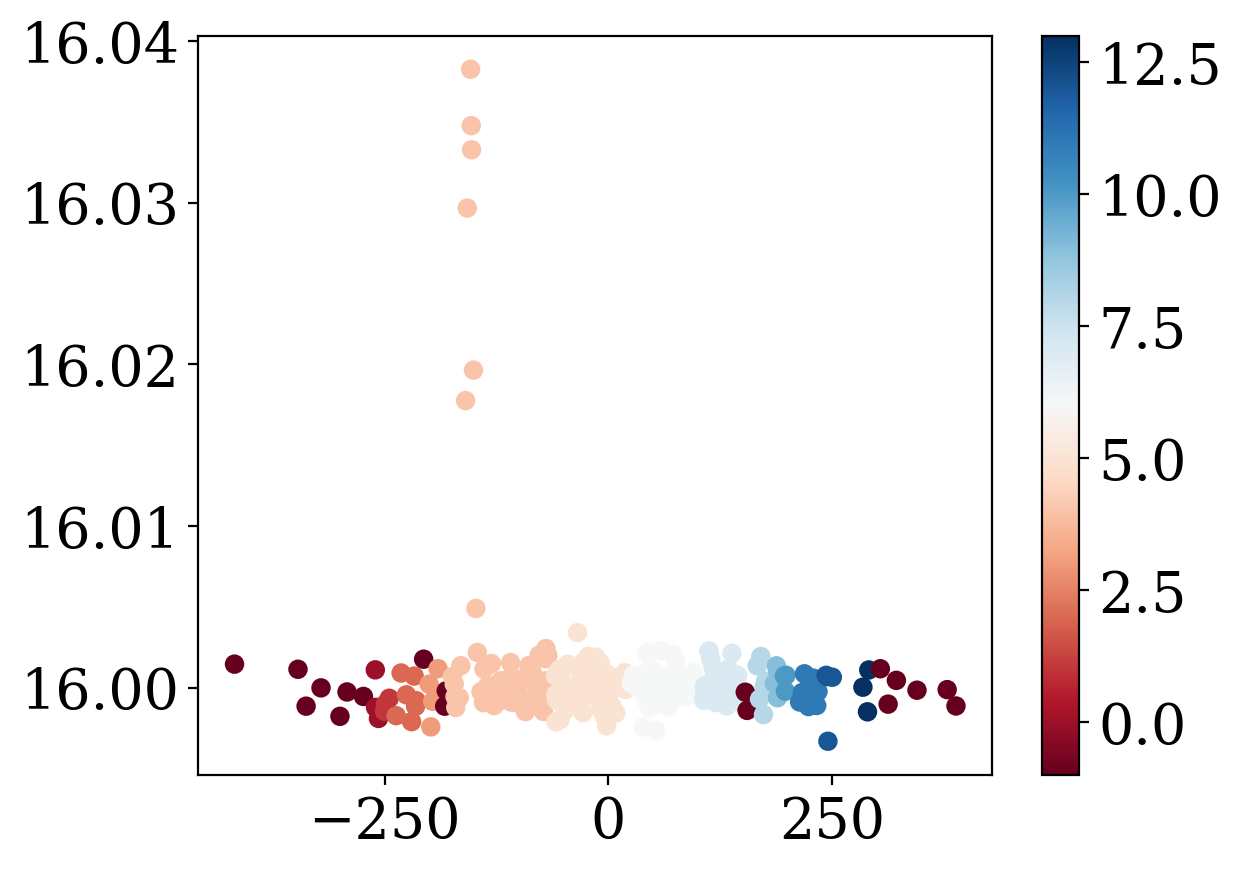

In [860]:
clustering = DBSCAN(eps=6, min_samples=3).fit(X)

plt.scatter(X[:,0], X[:,1], c=clustering.labels_, 
           cmap='RdBu')
plt.colorbar()


In [861]:
[clustering.labels_==5]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

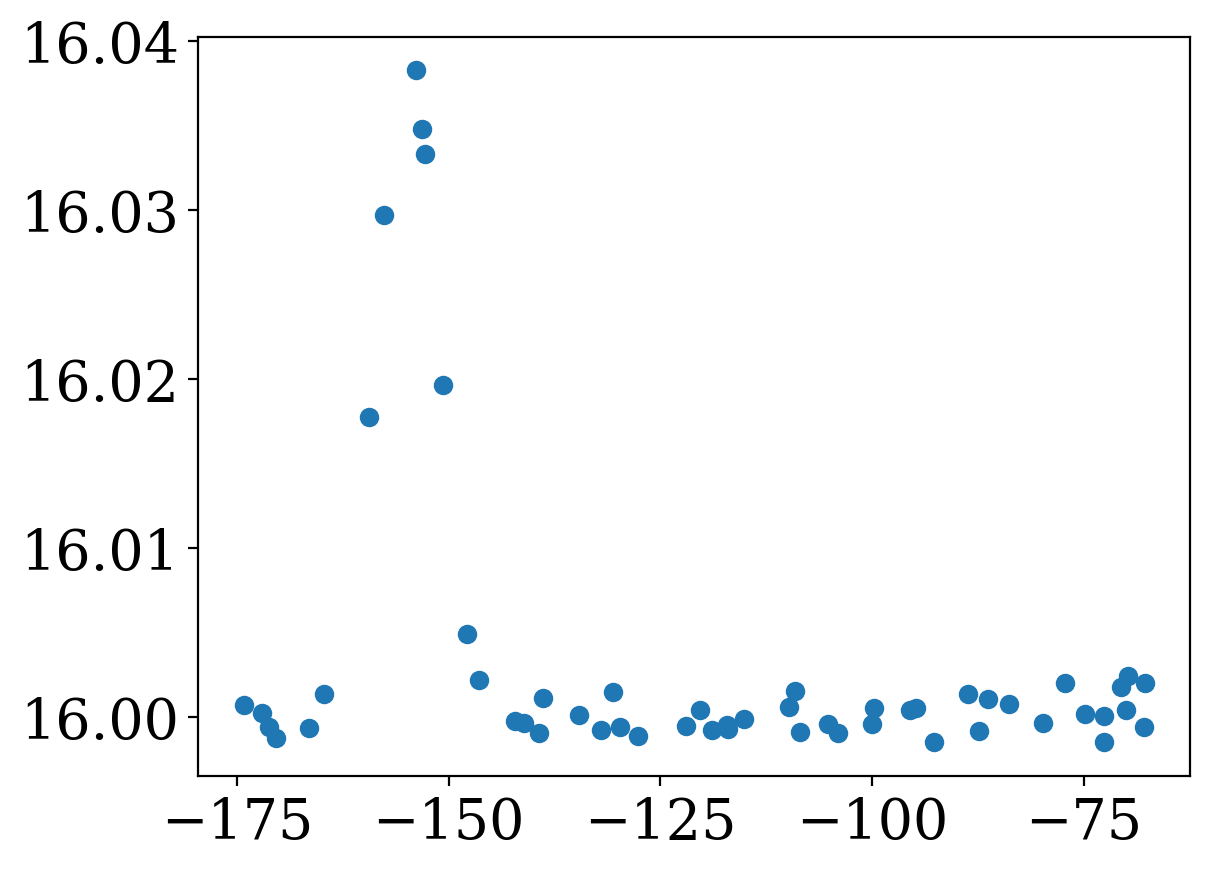

In [863]:
plt.scatter(X[:,0][clustering.labels_==4], X[:,1][clustering.labels_==4])

In [805]:
clustering.labels_

array([ 0,  0,  0, ...,  7,  7, 11])

## Simple GP with Minimziation

In [507]:
gp1 = gp_my_data.simple_GP(time, model, model_err)

In [508]:
gp1[-2]

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -610.4350464124344
        x: [ 5.206e+00  1.598e+01]
      nit: 63
      jac: [ 1.258e-04 -3.881e-05]
 hess_inv: [[ 1.546e-02  2.683e-02]
            [ 2.683e-02  6.056e-02]]
     nfev: 116
     njev: 104

Text(0, 0.5, 'Mag')

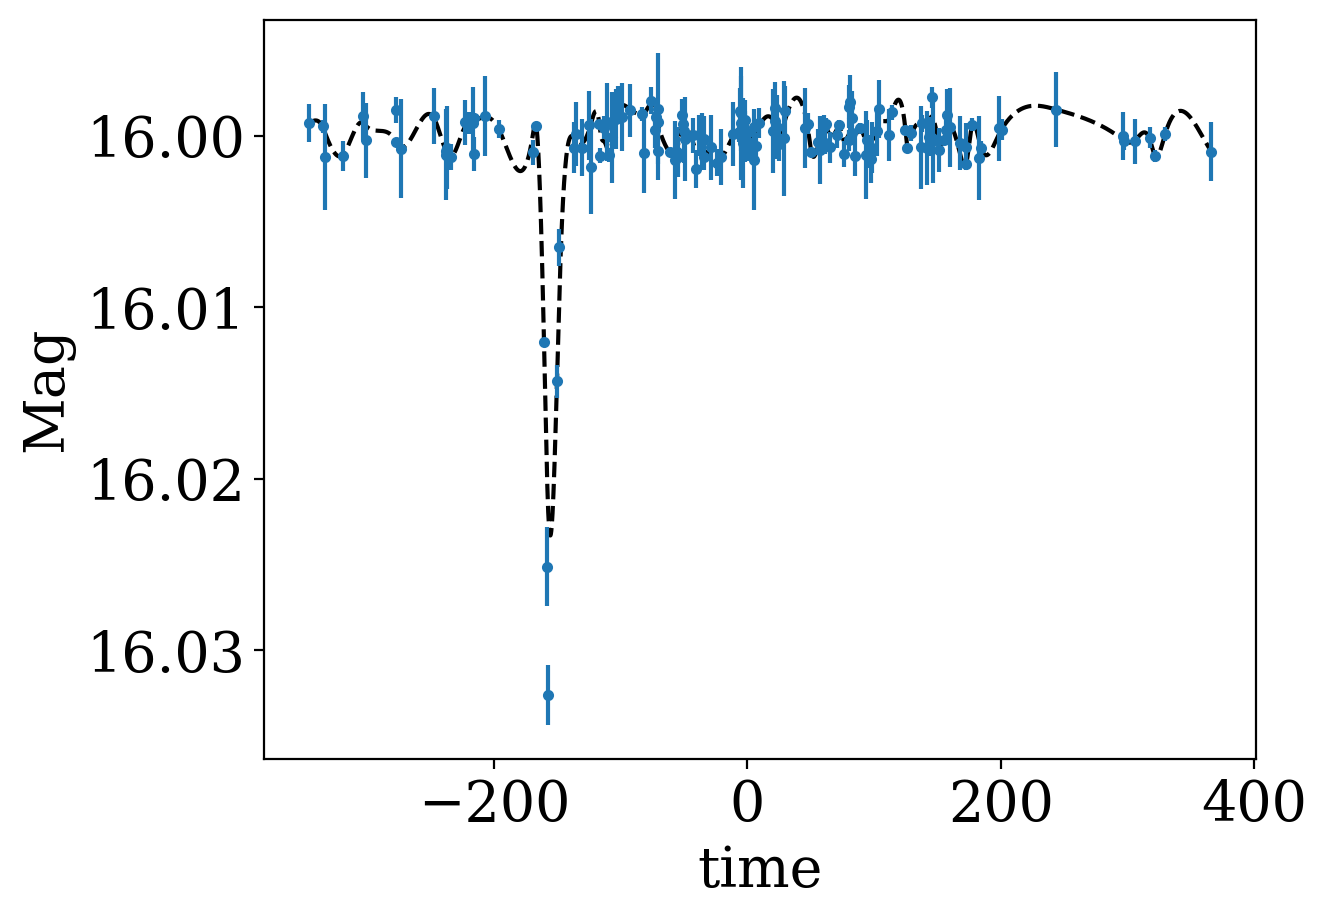

In [509]:
plt.plot(gp1[0], gp1[1], color='k', ls='--')
plt.errorbar(time, model, model_err, fmt='.')
plt.ylim(plt.ylim()[::-1])
plt.xlabel("time")
plt.ylabel("Mag")


In [406]:
def get_value(t, amp, location, sigma, log_sigma2): 
    return amp * np.exp(-0.5*(t.flatten()-location)**2/(sigma**2) * np.exp(-log_sigma2))

In [407]:
init = dict(amp=1, location=0, sigma=30, log_sigma2=1)

In [408]:
gpx = gp_my_data.model_gp_minimize(time, model, model_err, -250, 0, init)

In [409]:
gpx[-1].x

array([ 6.21932528e-03,  2.37480977e-01,  5.00000000e+00, -1.29669510e-09,
        2.49708662e+00,  1.00000000e+01])

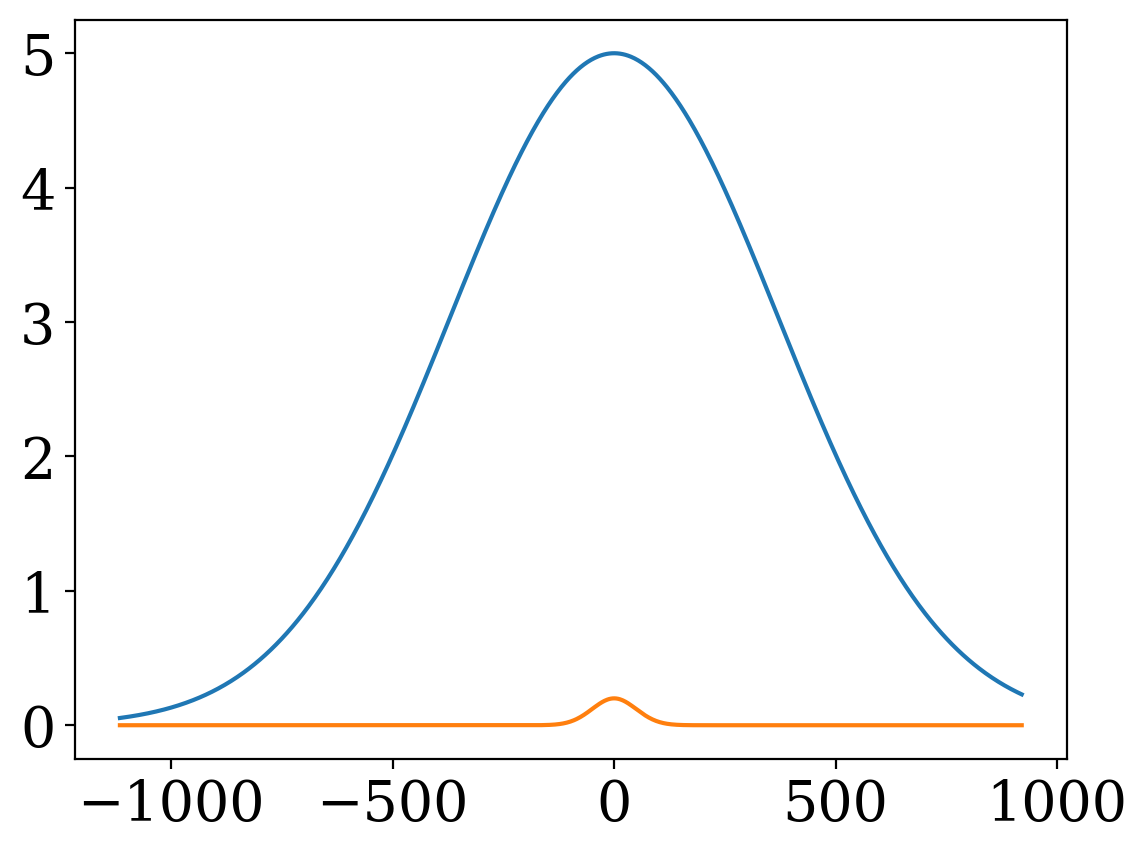

In [410]:
xx = np.linspace(min(time), max(time), 1000)
plt.plot(xx, get_value(xx, *gpx[-1].x[2::]))
plt.plot(xx, get_value(xx, 0.2, 0, 30, 1))

<ErrorbarContainer object of 3 artists>

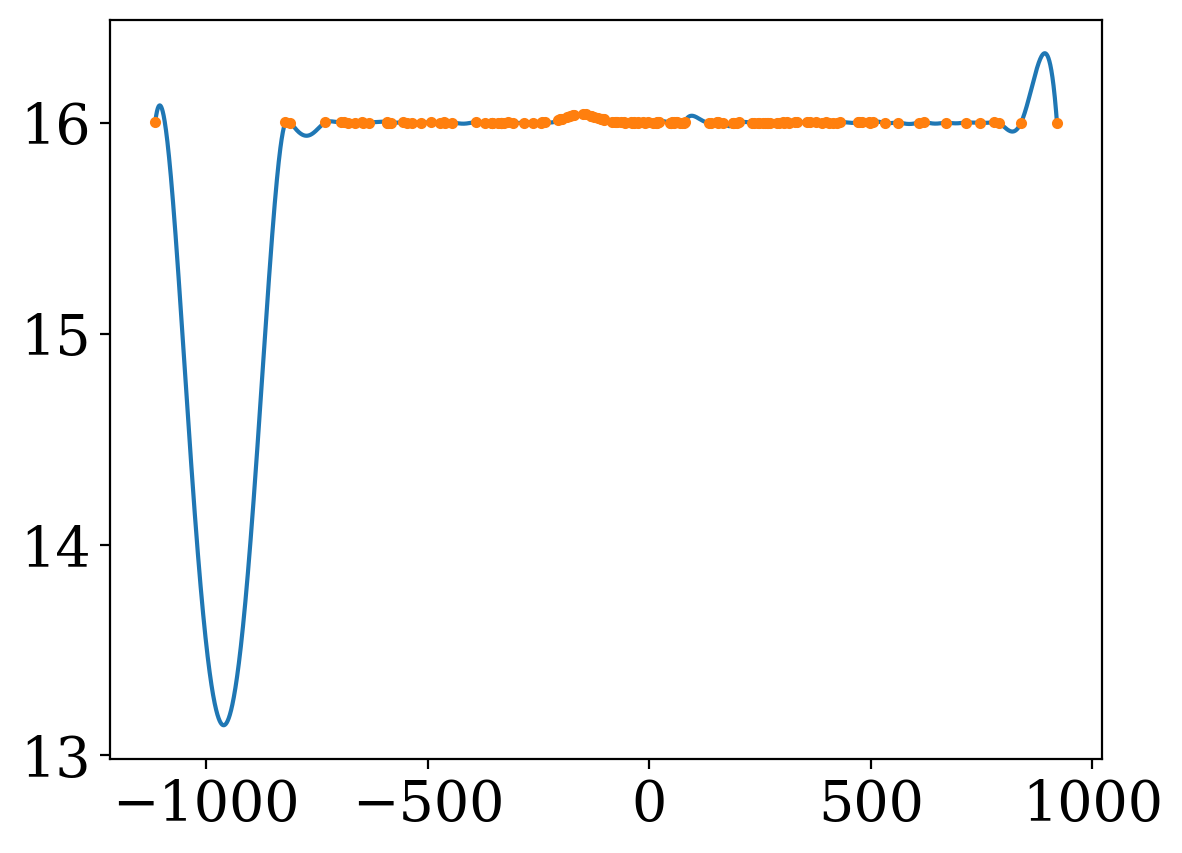

In [411]:
plt.plot(gpx[0], gpx[1])
plt.errorbar(time, model, model_err, fmt='.')

